# MSDS 610 Final Project Part II - Oussama Ennaciri

## Part VI : Constructing The Optimal Model - End

In [155]:
from IPython.display import Image
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
from sqlalchemy import create_engine
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [156]:
loaded_model = joblib.load("airbnb_model.joblib")

In [157]:
X_val = pd.read_csv("X_val.csv")
y_val = pd.read_csv("y_val.csv")

In [158]:
y_val_pred = loaded_model.predict(X_val)
y_val_pred

array([127.64745309, 129.13103648,  56.75025085, 106.86001446,
       121.85284094,  75.24222718,  70.91490412, 125.11095309,
       107.02693334, 147.28233466, 121.23394481, 148.54016927,
       111.22674056, 149.00310436,  75.53456764,  68.31031467,
        50.90121527,  61.87267126, 100.98745304, 150.2619088 ,
       104.82655445, 106.39626045, 119.31459723, 105.2313301 ,
       104.32108374,  97.0794451 , 120.34100866, 163.02036187,
        81.82738285, 147.51918376,  99.88771284,  47.70904894,
       111.100409  , 122.35145142,  73.93331447, 120.02403662,
       164.07696497,  81.88127727, 127.05020493, 120.55713439,
       136.2089568 , 103.4416891 , 107.63233974,  86.2726857 ,
       149.61146698, 122.42239741, 106.88126613,  61.77131622,
        57.97990357,  57.54216013,  62.3146884 , 145.02429378,
       137.07582549, 119.63761011,  88.33554602, 122.98774888,
       114.56816909,  55.46218748, 101.58812801, 122.03357467,
       131.08451209, 163.75269247,  80.18870137, 143.85

In [159]:
y_val_pred_df = pd.DataFrame(y_val_pred, columns=['price_Prediction'])


In [160]:
host = r'127.0.0.1'
db = r'MSDS610 - Final Project' 
user = r'postgres'
pw = r'password' 
port = r'5432'
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db)) 
schema = r'analytics' 

### Storing predictions from the validation set in the database

In [161]:
table_name = "price_predictions"
schema = "analytics" 

y_val_pred_df.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')


852

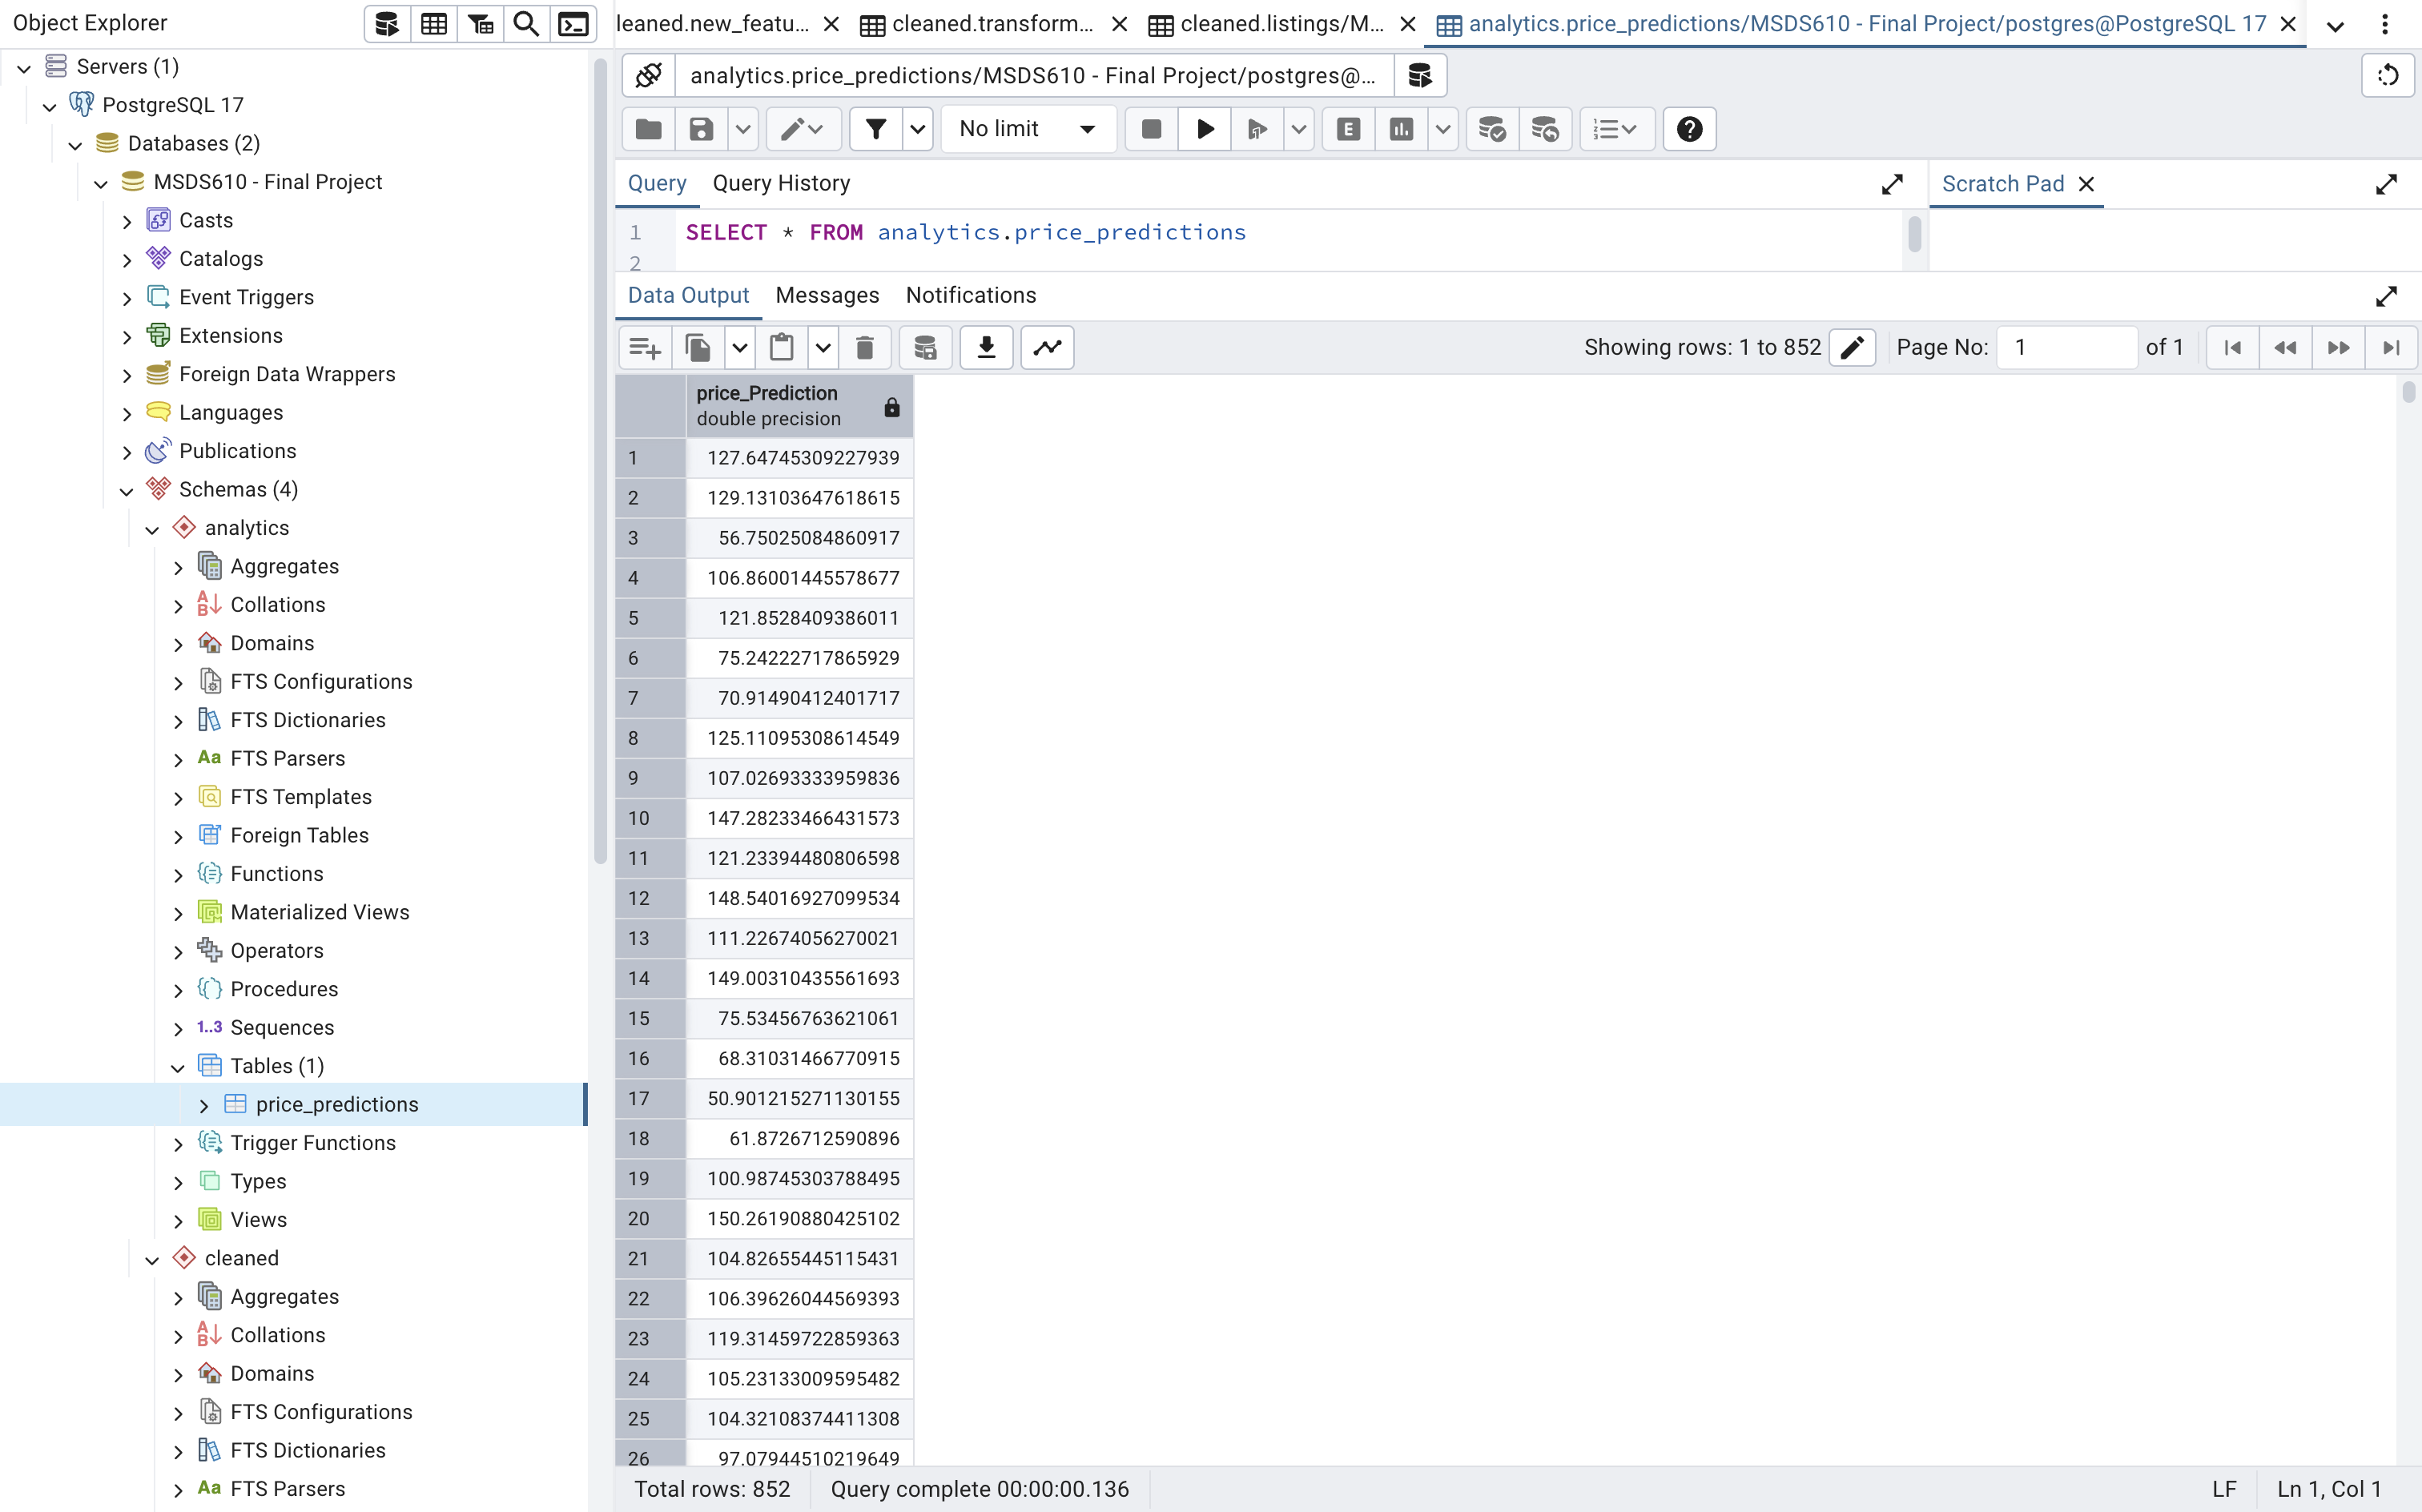

In [162]:
Image("price_prediction.png")

## Part VII : Executing with Live Data

I loaded the live data and the reference tables and applied the same transformations as I did to the original dataset using the reference tables. This included encoding categorical features, handling missing values, and calculating new features like distance_to_center. I also  corrected the order of the column in the live dataset as it should be in the same order as the dataset the model was trained on.


In [163]:
live = pd.read_csv("listings_live.csv")

In [164]:
host = r'127.0.0.1'
db = r'MSDS610 - Final Project'
user = r'postgres'
pw = r'password'
port = r'5432'
schema = r'cleaned' 
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [165]:
transformation_log = pd.read_sql("SELECT * FROM cleaned.transformation_log", db_conn)
transformation_log

,field_name,manipulation_type,value
0,id,Drop Column,Not Relevant for Pricing
1,name,Drop Column,Not Relevant for Pricing
2,host_id,Drop Column,Not Relevant for Pricing
3,host_name,Drop Column,Not Relevant for Pricing
4,neighbourhood_group,Drop Column,No Data
5,last_review,Fill Missing with earliest date & Convert to D...,2013-08-18
6,reviews_per_month,Fill Missing,0.0
7,neighbourhood_encoded,Mean Encoding & Drop Column,Average Price per Neighbourhood
8,room_type_encoded,Mean Encoding & Drop Column,Average Price per Room Type
9,minimum_nights,Drop Column,Weak Correlation


In [166]:
new_features_log = pd.read_sql("SELECT * FROM cleaned.new_features_log", db_conn)
new_features_log

,field_name,manipulation_type,value
0,last_review,Convert to Datetime & Drop Column,Datetime format
1,days_since_last_review,Calculate Days Since Last Review,Max observed days
2,latitude,Drop Column,No longer needed after distance calculation
3,longitude,Drop Column,No longer needed after distance calculation
4,distance_to_center,Calculate Distance to Downtown & Add Column,Distance in miles to downtown Chicago
5,"price, neighbourhood_encoded, room_type_encoded",Remove Outliers using IQR,Remove values outside 1.5 * IQR range
6,days_since_last_review,Drop Column,Removed after feature engineering
7,number_of_reviews,Drop Column,Weak correlation with target


In [167]:
live["distance_to_center"] = live.apply(
    lambda row: geodesic((row["latitude"], row["longitude"]), (41.881832, -87.623177)).miles, 
    axis=1
)
live = live.drop(columns=['latitude','longitude'])

In [168]:
live = live.drop(columns=['id', 'name', 'host_id', 'host_name','neighbourhood_group','minimum_nights','calculated_host_listings_count','last_review','number_of_reviews'])

In [169]:
live['reviews_per_month'].fillna(0.0, inplace=True)

In [170]:
live['neighbourhood_encoded'] = live.groupby('neighbourhood')['price'].transform('mean')
live['room_type_encoded'] = live.groupby('room_type')['price'].transform('mean')
live = live.drop(columns=['neighbourhood','room_type'])

In [171]:
print(f"Original shape: {live.shape}")
column = 'price' 
Q1 = live[column].quantile(0.25)
Q3 = live[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
live = live[(live[column] >= lower_bound) & (live[column] <= upper_bound)]
print(f"Cleaned shape: {live.shape}")

Original shape: (100, 6)
Cleaned shape: (93, 6)


In [172]:
print(f"Original shape: {live.shape}")
column = 'neighbourhood_encoded' 
Q1 = live[column].quantile(0.25)
Q3 = live[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
live = live[(live[column] >= lower_bound) & (live[column] <= upper_bound)]
print(f"Cleaned shape: {live.shape}")

Original shape: (93, 6)
Cleaned shape: (91, 6)


In [173]:
print(f"Original shape: {live.shape}")
column = 'room_type_encoded' 
Q1 = live[column].quantile(0.25)
Q3 = live[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
live = live[(live[column] >= lower_bound) & (live[column] <= upper_bound)]
print(f"Cleaned shape: {live.shape}")

Original shape: (91, 6)
Cleaned shape: (91, 6)


In [174]:
required_columns = ['price', 'reviews_per_month', 'availability_365', 
                    'neighbourhood_encoded', 'room_type_encoded', 'distance_to_center']
live = live[required_columns]

I generate a prediction of each row of the live data and appended the prediction to the raw live dataset to be able to compare.

In [175]:
feature_cols = [col for col in live.columns if col != 'price']
X_live = live[feature_cols]
predictions = loaded_model.predict(X_live)
live['predicted_price'] = predictions
live

,price,reviews_per_month,availability_365,neighbourhood_encoded,room_type_encoded,distance_to_center,predicted_price
0,200,0.14,365,137.500000,149.5,2.355002,119.306691
1,44,0.00,1,85.800000,70.0,4.997714,44.305797
2,45,1.00,357,45.000000,70.0,10.712834,34.955468
3,255,1.09,342,194.727273,149.5,2.113245,127.117586
4,55,1.42,364,55.000000,70.0,4.788876,45.066556
...,...,...,...,...,...,...,...
95,155,0.00,364,138.166667,149.5,0.585961,122.878064
96,25,1.93,158,101.500000,70.0,2.239430,49.440083
97,159,2.28,87,125.272727,149.5,3.045062,95.830477
98,144,0.00,0,194.727273,149.5,1.220005,120.740864


## Part VIII : Storing the Predictions

In [176]:
host = r'127.0.0.1'
db = r'MSDS610 - Final Project'
user = r'postgres'
pw = r'password'
port = r'5432'
schema = r'raw' 
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [177]:
listings_live = pd.read_sql("SELECT * FROM raw.listings_live", db_conn)
listings_live['predicted_price'] = live['predicted_price']
listings_live.to_sql('listings_live', db_conn, schema='raw', if_exists='replace', index=False)
listings_live = listings_live.dropna(subset=['predicted_price'])
listings_live


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,predicted_price
0,40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,None,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365,119.306691
1,45438479,English Lavender Room,258297883,Darkhan,None,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,None,NaN,3,1,44.305797
2,39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,None,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357,34.955468
3,35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,None,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342,127.117586
4,1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,None,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364,45.066556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16616242,1BR LUX in Loop. Excellent spot!,63313003,K,None,Loop,41.88679,-87.63240,Entire home/apt,155,30,0,None,NaN,31,364,122.878064
96,40068740,"CLEAN DOWNTOWN APARTMENT, SAFE AREA + FREE PAR...",55976787,Natalia,None,Near West Side,41.87147,-87.66432,Private room,25,10,20,2020-04-17,1.93,11,158,49.440083
97,24965357,Skylit Boho Retreat - Wicker Park NO PARTIES,1649647,Bianca,None,West Town,41.91162,-87.66674,Entire home/apt,159,2,65,2020-09-06,2.28,5,87,95.830477
98,42951283,"Bright Gold Coast 1BR w/ Gym, Lounge, nr. Oak ...",107434423,Blueground,None,Near North Side,41.89880,-87.62981,Entire home/apt,144,30,0,None,NaN,205,0,120.740864


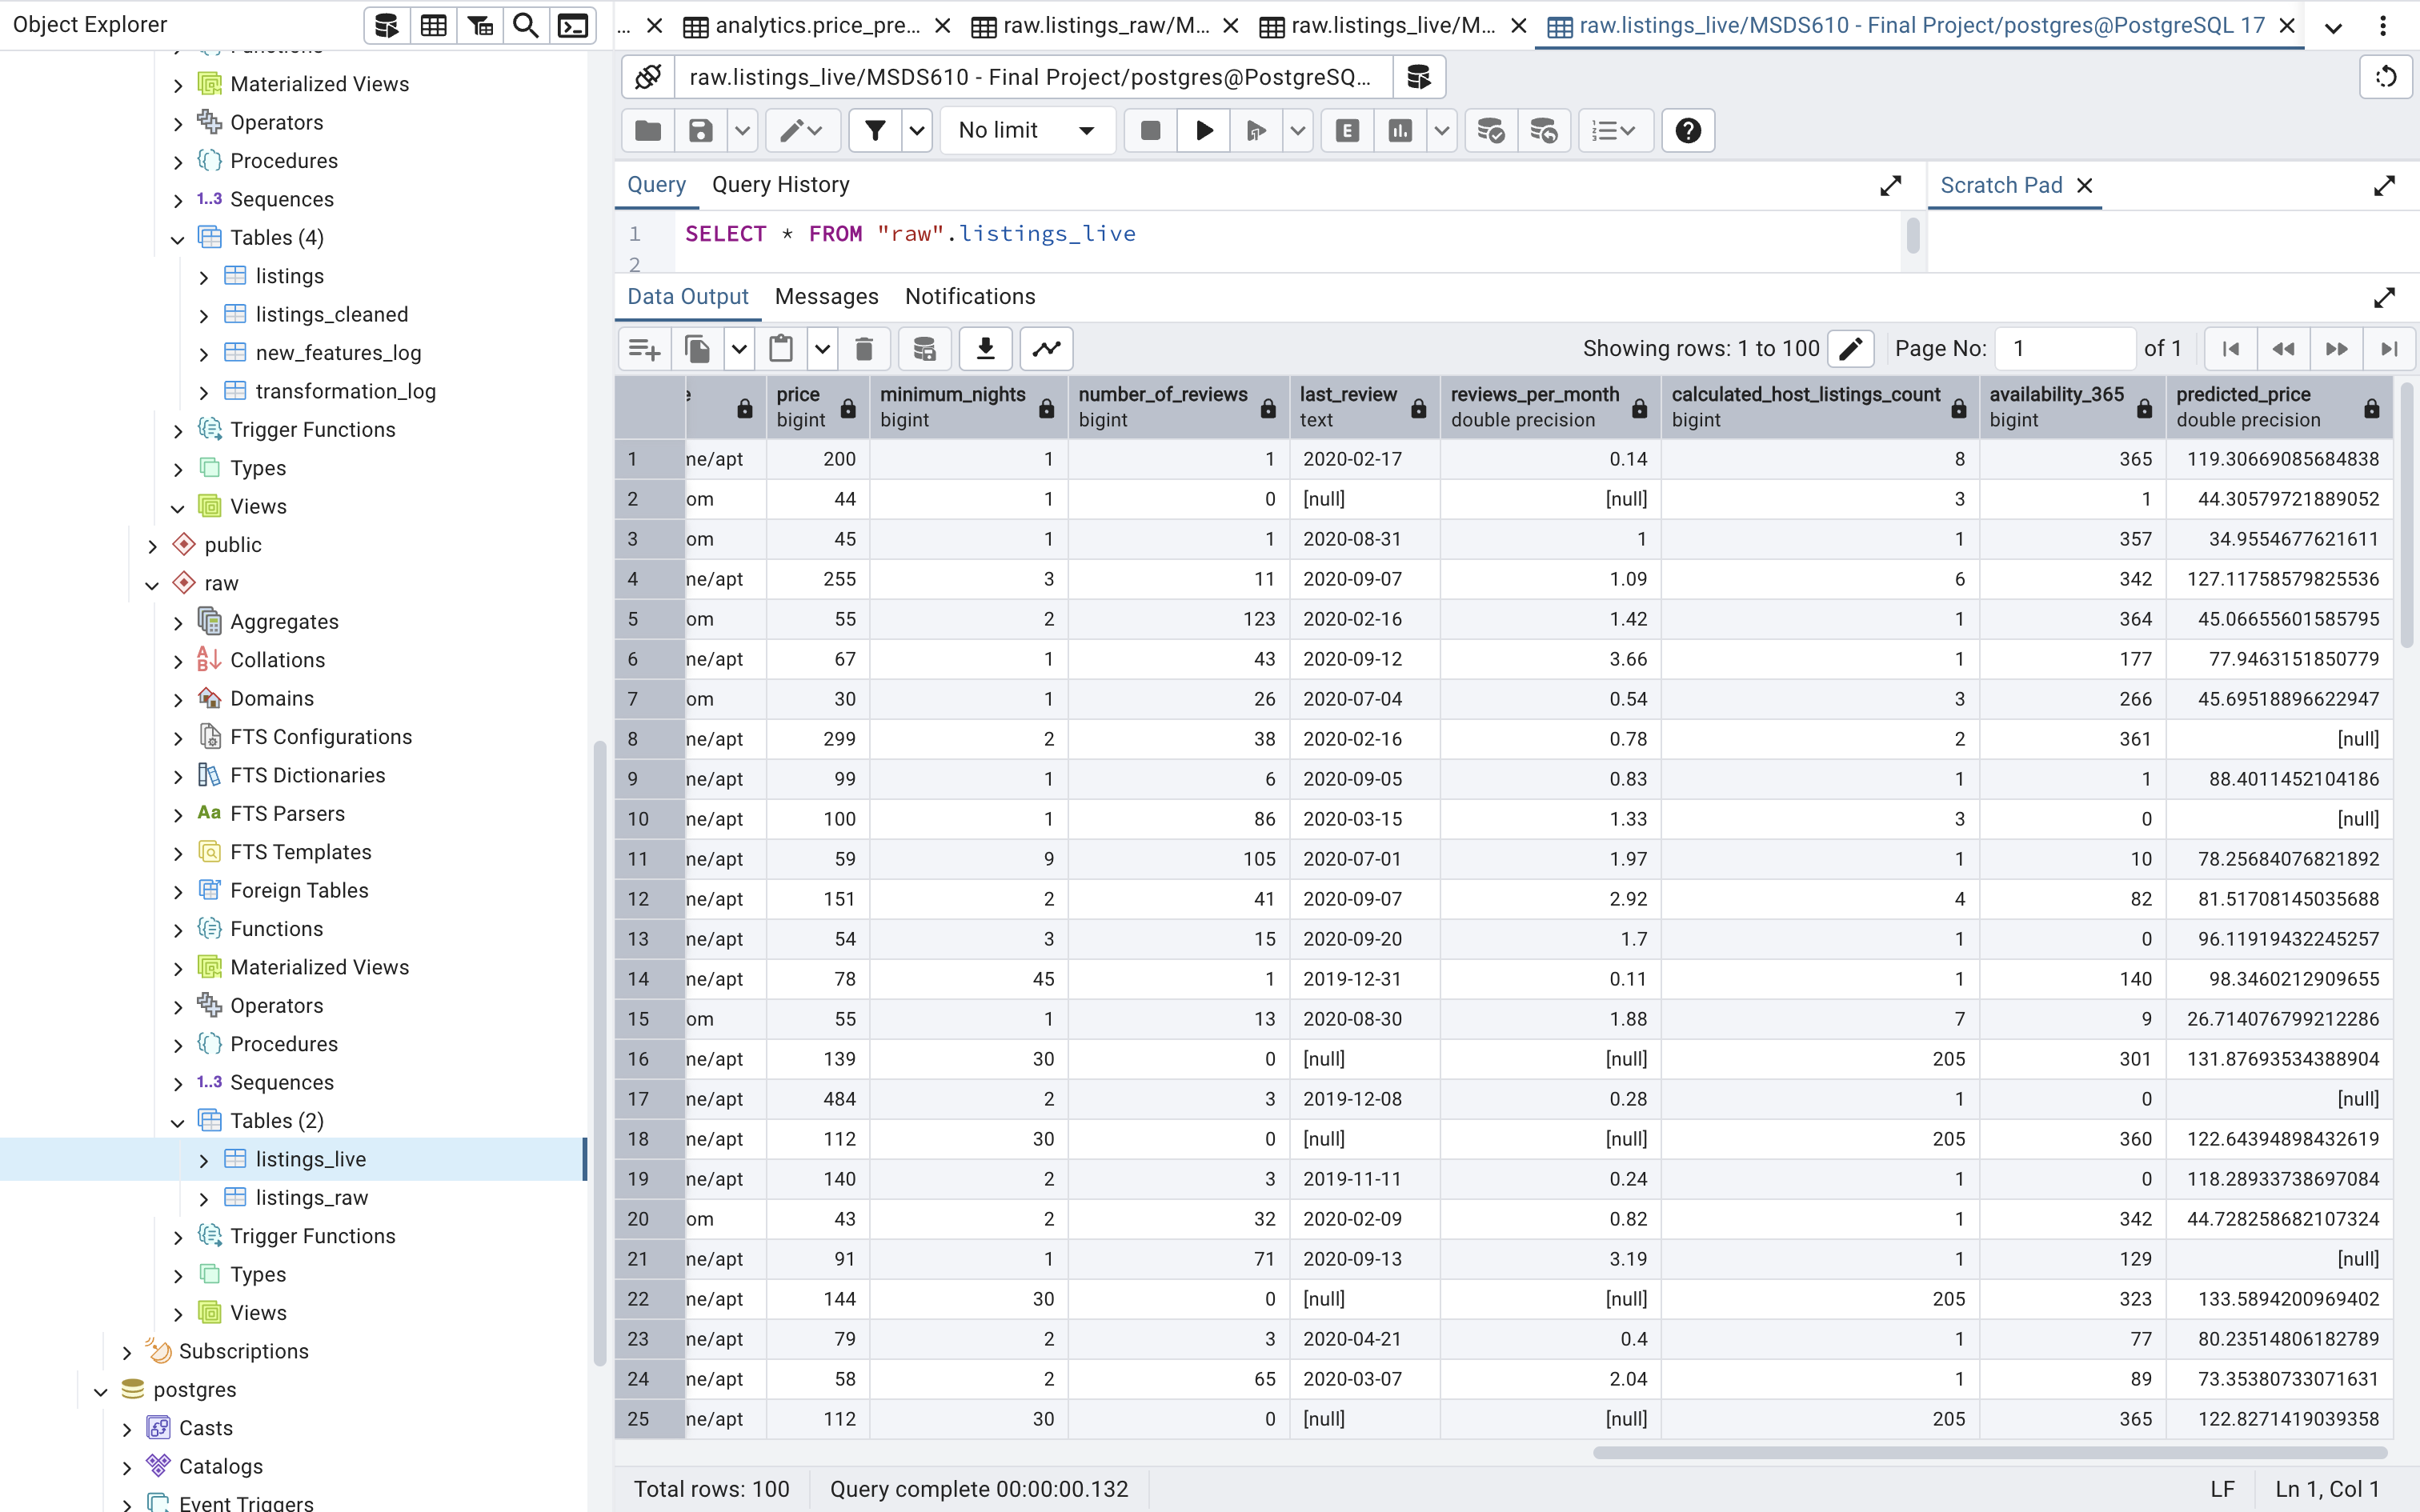

In [178]:
Image("live_predictions.png")

## Part IX : Insights

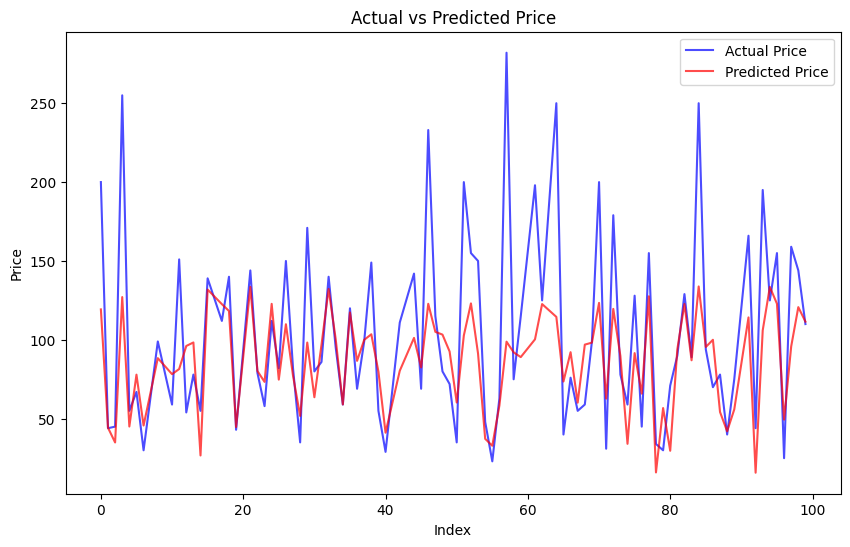

In [181]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(listings_live['price'], label='Actual Price', color='blue', alpha=0.7)
plt.plot(listings_live['predicted_price'], label='Predicted Price', color='red', alpha=0.7)
plt.title('Actual vs Predicted Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


There are clear differences between the actual prices and the prices predicted by the machine learning model. In some cases, the predictions are close, especially for lower-priced listings around $44 or $45. However, for more expensive listings, the model tends to predict lower prices than the actual ones. For example, a listing priced at $200 is predicted to be around $119, and another at $255 is predicted at $127. This could be because the model was trained without higher-priced listings, possibly due to outlier removal. Adjusting the model or adding more data might help improve accuracy. This model could be helpful for us if the dwelling we chose is of a lower to average pricing, but not if the price is high.

## Part X : Reflection

I very much enjoyed working on this project. It was satisfying to take it from start to finish, especially given its relevance. However, I encountered some challenges and identified areas where I want to deepen my knowledge.

One of the biggest challenges was finding features with a strong correlation to the target variable. I realized that the dataset might be missing important factors, such as the number of rooms and the floor on which a property is located, both of which can significantly impact price.

Additionally, I want to explore different machine learning models to expand my options and improve prediction accuracy. While I now have a better understanding of the steps involved in deploying a model to production, I know there’s still room for improvement. I want to develop a more solid foundation to confidently determine the best model for a given task, not just based on the target variable but also considering factors like dataset size.

I’m excited for my next project and the opportunity to build on what I’ve learned.